# 1. Introduction 
In this notebook, we will perform simple image classification using PyTorch. For the Dataset, we will use masker dataset image from kaggle.com<br>
First we need download the dataset

In [1]:
import pandas as pd
!pip install -q jcopdl

In [2]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d vijaykumar1799/face-mask-detection
! unzip -q /content/face-mask-detection.zip

Saving kaggle.json to kaggle.json
 91% 201M/222M [00:06<00:00, 23.7MB/s]
100% 222M/222M [00:06<00:00, 33.7MB/s]


In [3]:
import torch
from PIL import Image
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

because google colab has GPU hardware accelerator for instance runtime, we will use it since it will speed up training model

In this task, we will use MobileNet v2 as based model for transfer learning

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ImageFolder("/content/Dataset")
trainData, testData, trainLabel, testLabel = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42, stratify=dataset.targets)
device

device(type='cuda')

# 2. Dataset and ImageLoader

In [5]:
bs = 32
crop_size = 224

transformer = {
    "train": transforms.Compose([
        transforms.Resize(130),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(130),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ]),
}

In [6]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = self.checkChannel(dataset)
        self.transform = transform

    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            # if Image.open(dataset[index][0]).getbands() == ("R", "G", "B"):
            datasetRGB.append(dataset[index])
        return datasetRGB

    """def getResizedImage(self, item):
        image = Image.open(self.dataset[item][0])
        _, _ , width, height = image.getbbox()
        factor = (0,0,width,width) if width > height else (0,0,height,height)
        return image.crop(factor)"""

    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        image = image.convert("RGB")
        if self.transform is not None:
            return self.transform(image), self.dataset[item][1]
        return image, self.dataset[item][1]

    def __len__(self):
        return len(self.dataset)

train_set = ImageLoader(trainData, transformer["train"])
test_set = ImageLoader(testData, transformer["test"])

trainLoader = DataLoader(train_set, batch_size=bs, shuffle=True)
testLoader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [7]:
label2cat = dataset.classes

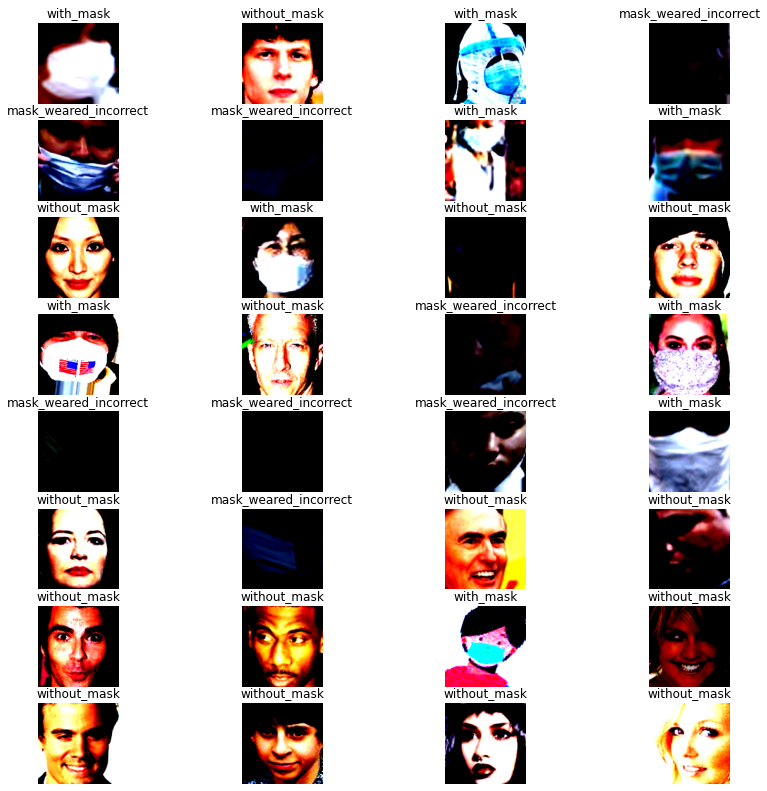

In [8]:
feature, target = next(iter(trainLoader))
fig, axes = plt.subplots(8, 4, figsize=(14, 14))

for f, t, ax in zip(feature, target, axes.flatten()):
    ax.imshow(f.permute(1, 2, 0))
    ax.set_title(label2cat[t])
    ax.axis("off")

In [9]:
from torchvision.models import mobilenet_v3_large
from torch import nn

In [10]:
class CustomMobilenet(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.classes = dataset
        self.mnet = mobilenet_v3_large(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(960, 1280, bias=True),
            nn.Hardswish(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(1280, len(self.classes)),
            nn.LogSoftmax()
        )
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [11]:
import torch
from jcopdl.callback import Callback, set_config

In [12]:
config = set_config({"batch_size": 32,"crop_size": 128})

# 3. MCOC (Model, Criterion, Optimizers, and Callback) 

In [13]:
model = CustomMobilenet(dataset=label2cat).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, early_stop_patience=2, outdir='model', plot_every=100)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [14]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [15]:
def looping():
    while True:
        train_cost, train_score = loop_fn("train", train_set, trainLoader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", test_set, testLoader, model, criterion, optimizer, device)
        
        # Logging
        callback.log(train_cost, test_cost, train_score, test_score)

        # Checkpoint
        callback.save_checkpoint()
            
        # Runtime Plotting
        callback.cost_runtime_plotting()
        callback.score_runtime_plotting()
        
        # Early Stopping
        if callback.early_stopping(model, monitor="test_score"):
            callback.plot_cost()
            callback.plot_score()
            break

# 4. Adaptation

Train:   0%|          | 0/225 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3601 | Test_cost  = 0.1756 | Train_score = 0.8870 | Test_score = 0.9466 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1902 | Test_cost  = 0.1259 | Train_score = 0.9331 | Test_score = 0.9577 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1567 | Test_cost  = 0.1144 | Train_score = 0.9442 | Test_score = 0.9599 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1285 | Test_cost  = 0.0991 | Train_score = 0.9546 | Test_score = 0.9638 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1179 | Test_cost  = 0.0893 | Train_score = 0.9589 | Test_score = 0.9699 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1108 | Test_cost  = 0.0920 | Train_score = 0.9613 | Test_score = 0.9661 |
==> EarlyStop patience =  1 | Best test_score: 0.9699


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.0971 | Test_cost  = 0.0769 | Train_score = 0.9656 | Test_score = 0.9733 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0992 | Test_cost  = 0.0715 | Train_score = 0.9644 | Test_score = 0.9766 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0952 | Test_cost  = 0.0712 | Train_score = 0.9663 | Test_score = 0.9727 |
==> EarlyStop patience =  1 | Best test_score: 0.9766


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.0903 | Test_cost  = 0.0663 | Train_score = 0.9706 | Test_score = 0.9777 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0834 | Test_cost  = 0.0655 | Train_score = 0.9713 | Test_score = 0.9800 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0796 | Test_cost  = 0.0651 | Train_score = 0.9706 | Test_score = 0.9800 |
==> EarlyStop patience =  1 | Best test_score: 0.9800


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.0721 | Test_cost  = 0.0614 | Train_score = 0.9736 | Test_score = 0.9816 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.0680 | Test_cost  = 0.0636 | Train_score = 0.9748 | Test_score = 0.9805 |
==> EarlyStop patience =  1 | Best test_score: 0.9816


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0633 | Test_cost  = 0.0557 | Train_score = 0.9768 | Test_score = 0.9850 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0660 | Test_cost  = 0.0602 | Train_score = 0.9754 | Test_score = 0.9761 |
==> EarlyStop patience =  1 | Best test_score: 0.9850


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0694 | Test_cost  = 0.0586 | Train_score = 0.9743 | Test_score = 0.9811 |
==> EarlyStop patience =  2 | Best test_score: 0.9850
==> Execute Early Stopping at epoch: 17 | Best test_score: 0.9850
==> Best model is saved at model


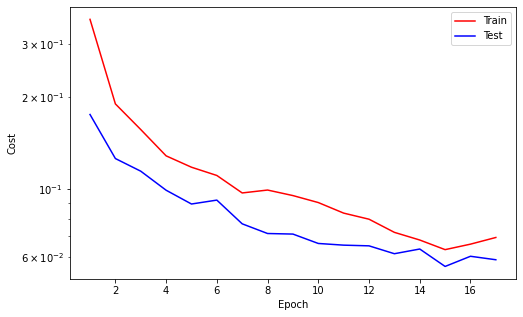

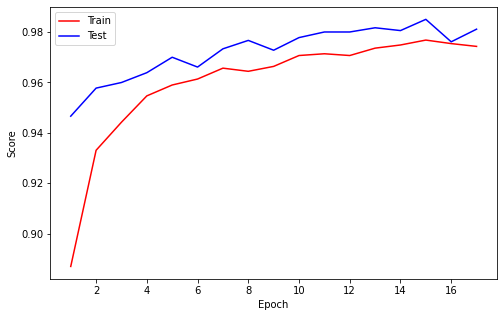

In [16]:
looping()

# 5. Fine Tuning

In [17]:
model.unfreeze()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
callback = Callback(model, config, early_stop_patience=5, outdir='model')

Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.0599 | Test_cost  = 0.0517 | Train_score = 0.9794 | Test_score = 0.9844 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.0569 | Test_cost  = 0.0490 | Train_score = 0.9794 | Test_score = 0.9861 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.0487 | Test_cost  = 0.0476 | Train_score = 0.9844 | Test_score = 0.9872 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.0477 | Test_cost  = 0.0458 | Train_score = 0.9851 | Test_score = 0.9883 |


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.0455 | Test_cost  = 0.0442 | Train_score = 0.9854 | Test_score = 0.9883 |
==> EarlyStop patience =  1 | Best test_score: 0.9883


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0418 | Test_cost  = 0.0431 | Train_score = 0.9864 | Test_score = 0.9883 |
==> EarlyStop patience =  2 | Best test_score: 0.9883


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.0399 | Test_cost  = 0.0431 | Train_score = 0.9865 | Test_score = 0.9878 |
==> EarlyStop patience =  3 | Best test_score: 0.9883


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0362 | Test_cost  = 0.0411 | Train_score = 0.9886 | Test_score = 0.9883 |
==> EarlyStop patience =  4 | Best test_score: 0.9883


Train:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0317 | Test_cost  = 0.0401 | Train_score = 0.9908 | Test_score = 0.9872 |
==> EarlyStop patience =  5 | Best test_score: 0.9883
==> Execute Early Stopping at epoch: 9 | Best test_score: 0.9883
==> Best model is saved at model


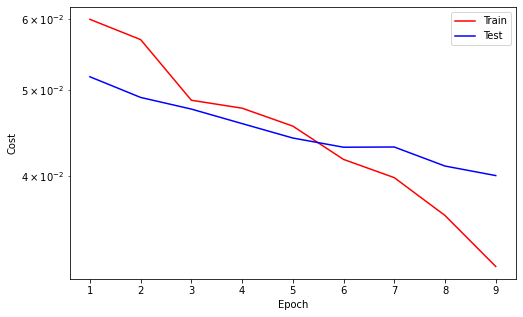

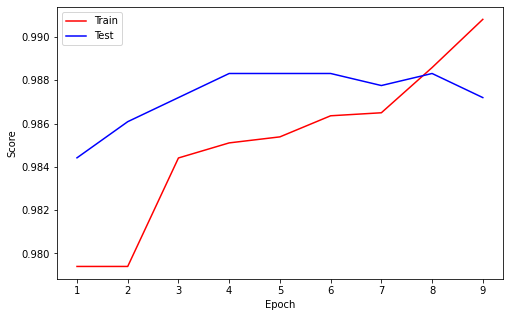

In [18]:
looping()

# 6. Sanity Check

In [19]:
def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485    
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

In [20]:
feature, target = next(iter(testLoader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 0, 2, 0, 1, 2, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 1, 1, 2, 2, 0, 1, 2,
        0, 2, 0, 2, 1, 2, 0, 1], device='cuda:0')

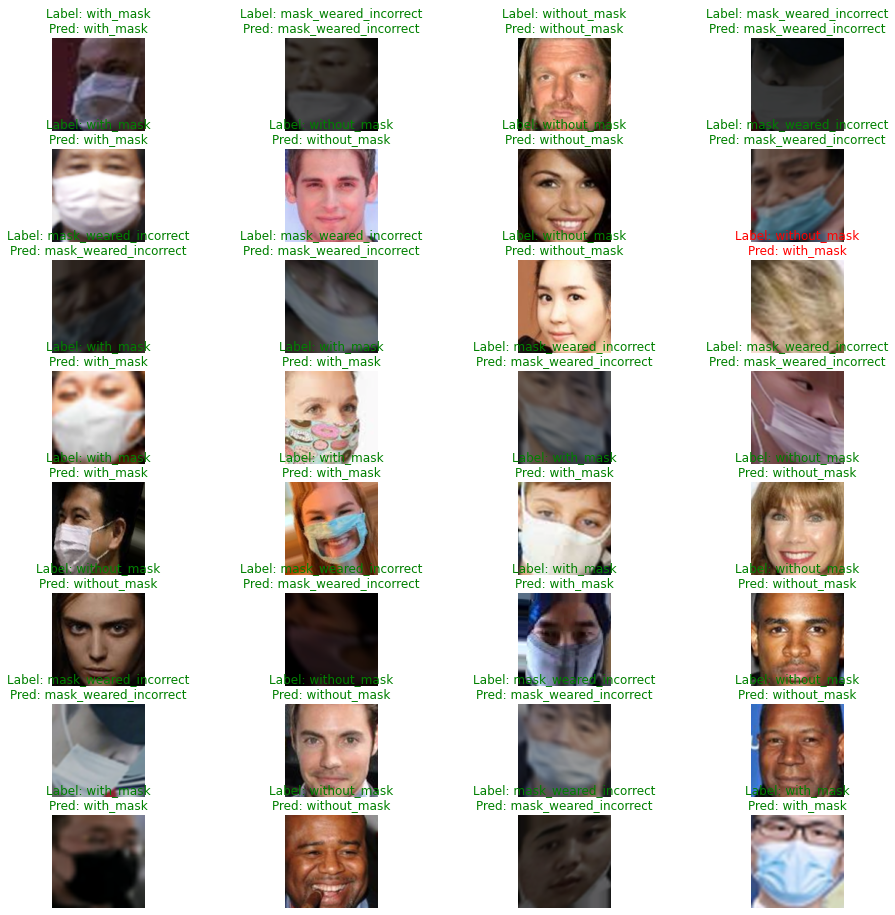

In [21]:
fig, axes = plt.subplots(8, 4, figsize=(16,16))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
    font = {"color": "r"} if (pred != label).any() else {"color": "g"}
    label, pred = label2cat[label], label2cat[pred]
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font)
    ax.axis('off')

# Model have 98% accuracy